In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
imdb, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteS4AB05/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteS4AB05/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteS4AB05/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
def create_dataset(data, train=None, test=None):
  sentences = []
  labels = []
  if train:
    for s, l in data['train']:
      sentence = s.numpy().decode('utf-8')
      label = l.numpy()
      sentences.append(sentence)
      labels.append(label)
  
  if test:
    for s, l in data['test']:
      sentence = s.numpy().decode('utf-8')
      label = l.numpy()
      sentences.append(sentence)
      labels.append(label)
  
  labels = np.array(labels)
  return sentences, labels

In [4]:
# train_sentences = []
# train_labels = []

# test_sentences = []
# test_labels = []

# for s, l in imdb['train']:
#   sentence = s.numpy().decode('utf-8')
#   label = np.array(l.numpy())
#   train_sentences.append(sentence)
#   train_labels.append(label)

# for s, l in imdb['test']:
#   sentence = s.numpy().decode('utf-8')
#   label = l.numpy()
#   test_sentences.append(sentence)
#   test_labels.append(label)

# # train_labels = np.array(train_labels)
# test_labels = np.array(test_labels)

In [6]:
train_sentences, train_labels = create_dataset(imdb, train=True)
test_sentences, test_labels = create_dataset(imdb, test=True)

In [7]:
train_sentences[:5]
train_labels[:5]

array([0, 0, 0, 1, 1])

In [8]:
VOCAB_SIZE=10000
MAX_LEN=120
OOV_TOKEN="<OOV>"
TRUNC_TYPE = 'post'
PAD_TYPE = 'post'

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)

tokenizer.fit_on_texts(train_sentences)

In [9]:
word_index = tokenizer.word_index
for i in range(5):
  print(list(word_index.keys())[i], list(word_index.values())[i])
  

<OOV> 1
the 2
and 3
a 4
of 5


In [10]:
sequences = tokenizer.texts_to_sequences(train_sentences)
padded = pad_sequences(sequences, padding=PAD_TYPE, truncating=TRUNC_TYPE, maxlen=MAX_LEN)

In [11]:
testing_sequences = tokenizer.texts_to_sequences(test_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=MAX_LEN, padding=PAD_TYPE, truncating=TRUNC_TYPE)

In [12]:
def create_model(vocab_size, embedding_dims, max_length, model='LSTM'):
  if model == 'LSTM':
    model = tf.keras.layers.LSTM(64)
  elif model == 'GRU':
    model = tf.keras.layers.GRU(64)
  model = tf.keras.Sequential(
      [
      tf.keras.layers.Embedding(VOCAB_SIZE, embedding_dims, input_length=MAX_LEN),
      model,
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid'),
      ]
  )
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  
  model.summary()
  return model

In [13]:
EMBEDDING_DIMS = int(1.6 * np.sqrt(VOCAB_SIZE))
BATCH_SIZE = 128
NUM_EPOCHS = 15

LSTM_model = create_model(VOCAB_SIZE, 16, MAX_LEN, model='LSTM')
LSTM_history = LSTM_model.fit(padded, train_labels, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, test_labels) )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 lstm (LSTM)                 (None, 64)                20736     
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 181,793
Trainable params: 181,793
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
196/196 [==============================] - 15s 41ms/step - loss: 0.5799 - accuracy: 0.6587 - val_loss: 0.4400 - val_accuracy: 0.8109
Epoch 2/15
196/196 [==================

In [14]:
GRU_model = create_model(VOCAB_SIZE, 16, MAX_LEN, model='GRU')
GRU_history = GRU_model.fit(padded, train_labels, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, test_labels) )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           160000    
                                                                 
 gru (GRU)                   (None, 64)                15744     
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 176,801
Trainable params: 176,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
196/196 [==============================] - 10s 41ms/step - loss: 0.6209 - accuracy: 0.6201 - val_loss: 0.4329 - val_accuracy: 0.8088
Epoch 2/15
196/196 [================

In [15]:
import matplotlib.pyplot as plt
# Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

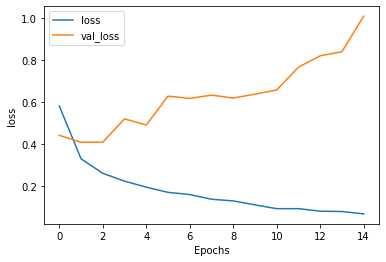

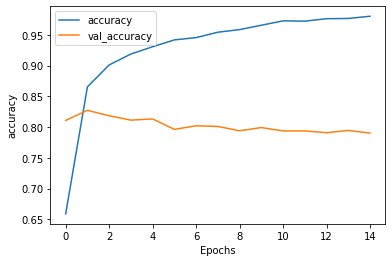

In [19]:
plot_graphs(LSTM_history, 'loss')
print()
plot_graphs(LSTM_history, 'accuracy')


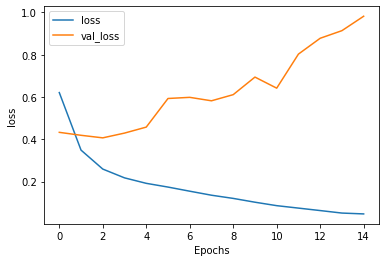

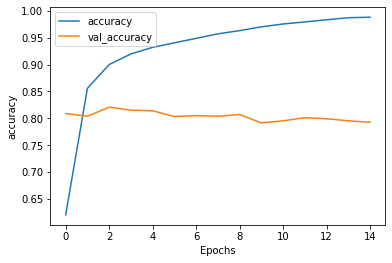

In [20]:
plot_graphs(GRU_history, 'loss')
print()
plot_graphs(GRU_history, 'accuracy')
